In [1]:
import sys
sys.path.append('../..')
import cortexetl as c_etl

In [ ]:
ma_frs = c_etl.analysis_initial_processing("/gpfs/bbp.cscs.ch/project/proj83/home/isbister/physiology_2023/cortexetl.configs/8-FRDistributionTest/8-FRDistributionTest-0-Test-etl3.yaml") #, loglevel="ERROR"

In [4]:
a_hex0 = ma_frs.hex0_spikes

In [86]:
import numpy as np

print(a_hex0.repo.simulations.df.simulation_id.unique())

simulation_id = 18

print(a_hex0.repo.simulations.df.etl.q(simulation_id=simulation_id))

window_spikes = a_hex0.repo.report.df.etl.q(window='conn_spont', neuron_class=c_etl.LAYER_EI_NEURON_CLASSES, simulation_id=simulation_id)


all_itis = []
all_ff_itis = []
low_ff_gids = []
low_ff_mean_iti = []
for i, gid in enumerate(window_spikes.gid.unique()):
    gid_sts = window_spikes.etl.q(gid=gid).time.to_numpy()
    
    if len(gid_sts) >=10:
        
        gid_itis = gid_sts[1:] - gid_sts[:-1]

        iti_ff = gid_itis.std() / gid_itis.mean()

        if iti_ff < 0.2:
            low_ff_gids.append(gid)
            low_ff_mean_iti.append(np.mean(gid_itis))

        all_itis.extend(gid_itis)
        all_ff_itis.append(iti_ff)

#         if i == 10000:
#             break
        


[ 1  2  3  6  8 11 13 16 18]
    ca  depol_stdev_mean_ratio  desired_connected_proportion_of_invivo_frs  \
8  1.1                     0.4                                         0.7   

                                     simulation_path  simulation_id  \
8  /gpfs/bbp.cscs.ch/project/proj83/scratch/bbp_w...             18   

   circuit_id                                         simulation  \
8           0  <blueetl.adapters.simulation.SimulationAdapter...   

                                             circuit simulation_string  \
8  <blueetl.adapters.circuit.CircuitAdapter objec...   (1.1, 0.7, 0.4)   

                                         figures_dir  \
8  /gpfs/bbp.cscs.ch/project/proj83/home/isbister...   

                                         rasters_dir  \
8  /gpfs/bbp.cscs.ch/project/proj83/home/isbister...   

                                             fft_dir  \
8  /gpfs/bbp.cscs.ch/project/proj83/home/isbister...   

                          flatspace_video_imag

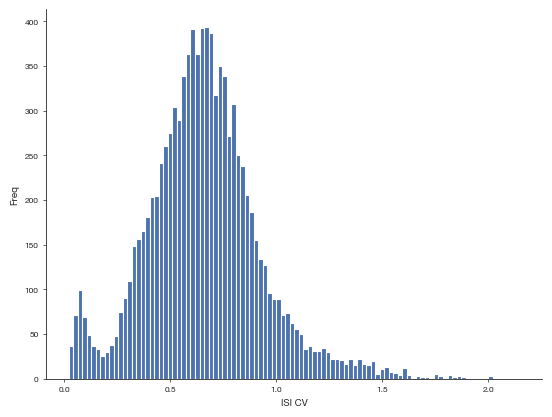

In [77]:
import matplotlib.pyplot as plt
# print(all_itis)

plt.figure()
plt.hist(all_ff_itis, bins=100)
plt.gca().set_xlabel('ISI CV')
plt.gca().set_ylabel('Freq')
plt.savefig('ISI_CV_Hist.pdf')
plt.show()
plt.close()

/nvme/isbister/1860414/ipykernel_101337/731560274.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_ff_window_spikes['zeroed_gid'] = low_ff_window_spikes.apply(lambda row : unique_low_ff_gids.index(row['gid']), axis = 1)


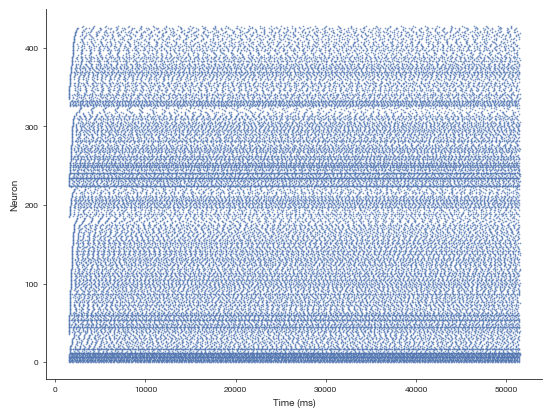

In [79]:
plt.figure()

low_ff_window_spikes = window_spikes.etl.q(gid=low_ff_gids)
# print(low_ff_window_spikes)

unique_low_ff_gids = list(low_ff_window_spikes.gid.unique())

low_ff_window_spikes['zeroed_gid'] = low_ff_window_spikes.apply(lambda row : unique_low_ff_gids.index(row['gid']), axis = 1)

plt.scatter(low_ff_window_spikes.time, low_ff_window_spikes.zeroed_gid, s=0.1)

plt.gca().set_ylabel('Neuron')
plt.gca().set_xlabel('Time (ms)')
plt.savefig('LT20pct_ISI_CV_Raster.pdf')
plt.show()
plt.close()

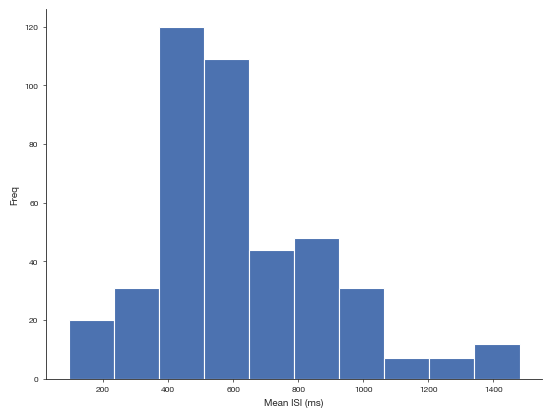

In [83]:
plt.figure()
plt.hist(np.asarray(low_ff_mean_iti))
plt.gca().set_xlabel('Mean ISI (ms)')
plt.gca().set_ylabel('Freq')
plt.savefig('LT20pct_Mean_ISI.pdf')

429
30190


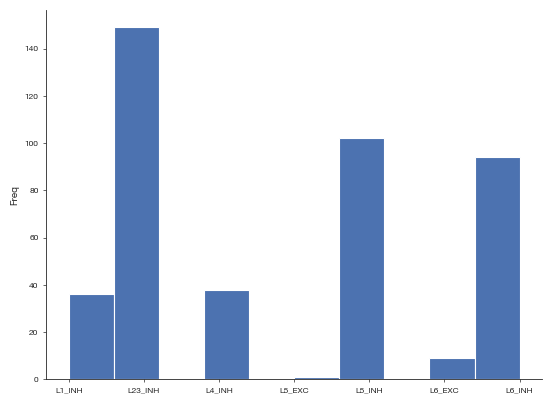

In [85]:
print(len(unique_low_ff_gids))
neurons = a_hex0.repo.neurons.df.etl.q(gid=unique_low_ff_gids, neuron_class=c_etl.LAYER_EI_NEURON_CLASSES)

print(len(a_hex0.repo.neurons.df.etl.q(neuron_class=c_etl.LAYER_EI_NEURON_CLASSES)))

plt.hist(neurons.neuron_class)
plt.gca().set_ylabel('Freq')
neurons.neuron_class.unique()
plt.savefig('LT20pct_ISI_CV_NeuronClasses.pdf')

In [111]:
low_ff_gid_hist_counts = []
for zeroed_gid in low_ff_window_spikes['zeroed_gid'].unique():
    gid_hist_counts, _ = np.histogram(low_ff_window_spikes.etl.q(zeroed_gid=zeroed_gid).time, bins=10000, range=(1500, 51500))
#     print(np.sum(gid_hist_counts))
    low_ff_gid_hist_counts.append(list(gid_hist_counts))
    
low_ff_gid_hist_counts = np.asarray(low_ff_gid_hist_counts)
print(low_ff_gid_hist_counts.shape)
    


(429, 10000)


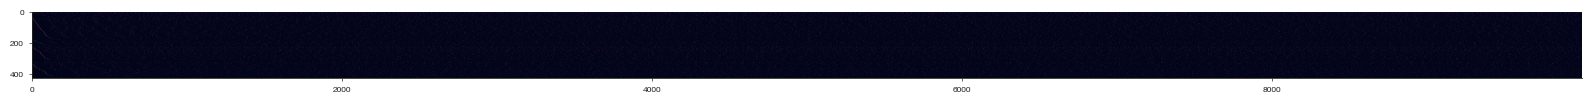

In [112]:
plt.figure(figsize=(20, 20))
plt.imshow(np.asarray(low_ff_gid_hist_counts))
plt.show()
plt.close()

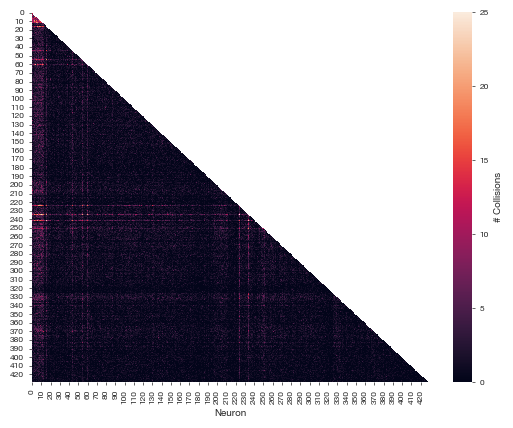

In [139]:
num_zeroed_gids = len(low_ff_window_spikes['zeroed_gid'].unique())

spike_collision_counts = np.ones((num_zeroed_gids, num_zeroed_gids)) * np.nan

for i in range(num_zeroed_gids):
    for j in range(num_zeroed_gids):
        if i > j:
            spike_collision_counts[i, j] = np.dot(low_ff_gid_hist_counts[i], low_ff_gid_hist_counts[j])

import seaborn as sns
plt.figure()
sns.heatmap(spike_collision_counts, cbar_kws={'label': '# Collisions'})
plt.gca().set_xlabel("Neuron")
plt.gca().set_xlabel("Neuron")
plt.savefig('LT20pct_NumCollisionsHeatmap.pdf')
plt.show()
plt.close()

(184041,)
(91806,)


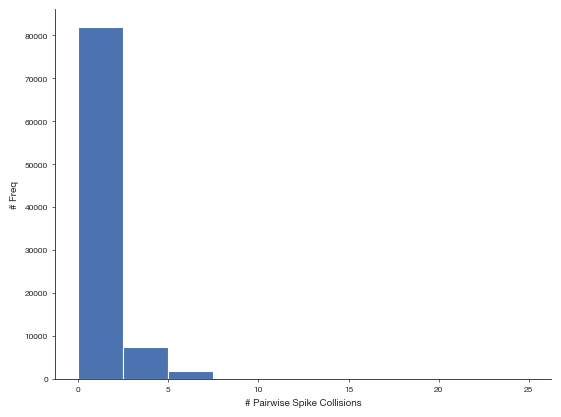

(50689, 1)


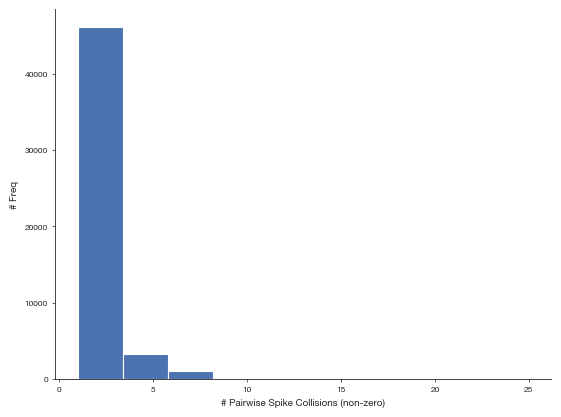

In [140]:
spike_collision_counts_flat = spike_collision_counts.flatten()
print(spike_collision_counts_flat.shape)

spike_collision_counts_flat = spike_collision_counts_flat[np.argwhere(np.logical_not(np.isnan(spike_collision_counts_flat)))].flatten()
print(spike_collision_counts_flat.shape)

plt.figure()
plt.hist(spike_collision_counts_flat)
plt.gca().set_xlabel("# Pairwise Spike Collisions")
plt.gca().set_ylabel("# Freq")
plt.savefig('LT20pct_NumCollisionsHist.pdf')
plt.show()
plt.close()

non_zero_spike_collision_counts_flat = spike_collision_counts_flat[np.argwhere(spike_collision_counts_flat > 0)]

print(non_zero_spike_collision_counts_flat.shape)

plt.figure()
plt.hist(non_zero_spike_collision_counts_flat)
plt.gca().set_xlabel("# Pairwise Spike Collisions (non-zero)")
plt.gca().set_ylabel("# Freq")
plt.savefig('LT20pct_NumCollisionsHistNonZero.pdf')
plt.show()
plt.close()